In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
     

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z9payt2e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z9payt2e
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from patchify import patchify, unpatchify #Only to handle large images
from transformers import SamModel, SamConfig, SamProcessor
import random
from scipy import ndimage
from PIL import Image

/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 03:50:47.156685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 03:50:48.202528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Load models and their configurations
model_config_1 = SamConfig.from_pretrained("facebook/sam-vit-base")
processor_1 = SamProcessor.from_pretrained("facebook/sam-vit-base")
model_seg_1 = SamModel(config=model_config_1)
model_seg_1.load_state_dict(torch.load("/data1/sprasad/maskingApproach2/vit_model_weights_1/model_epoch_59.pth"))
model_seg_1.to("cuda" if torch.cuda.is_available() else "cpu")

model_config_2 = SamConfig.from_pretrained("facebook/sam-vit-base")
processor_2 = SamProcessor.from_pretrained("facebook/sam-vit-base")
model_seg_2 = SamModel(config=model_config_2)
model_seg_2.load_state_dict(torch.load("/data1/sprasad/maskingApproach2/vit_model_weights_2/model_epoch_47.pth"))
model_seg_2.to("cuda" if torch.cuda.is_available() else "cpu")

# model_config_3 = SamConfig.from_pretrained("facebook/sam-vit-base")
# processor_3 = SamProcessor.from_pretrained("facebook/sam-vit-base")
# model_seg_3 = SamModel(config=model_config_3)
# model_seg_3.load_state_dict(torch.load("/data1/sprasad/maskingApproach2/vit_model_weights_3/model_epoch_64.pth"))
# model_seg_3.to("cuda" if torch.cuda.is_available() else "cpu")

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [5]:
# Functions to load and pad images
def load_and_pad_images_from_folder(folder, target_size=(1024, 1536)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB
            img_array = np.array(img)
            # Pad the image
            pad_width = ((0, 0), (0, target_size[1] - img_array.shape[1]), (0, 0))
            padded_img = np.pad(img_array, pad_width, mode='constant', constant_values=0)
            images.append(padded_img)
    return np.array(images)


def load_and_pad_masks_from_folder(folder, target_size=(1024, 1536)):
    masks = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            mask = np.load(img_path)
            # Pad the mask
            pad_width = ((0, 0), (0, target_size[1] - mask.shape[1]))
            padded_mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
            masks.append(padded_mask)
    return np.array(masks)


def get_image_ids_from_folder(folder_path):
    image_ids = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG"):
            image_id = filename.split('.')[0]
            image_ids.append(image_id)
    return image_ids

In [6]:
# Load and pad images and masks
output_directory = "/data1/sprasad/baseline/pred"
os.makedirs(output_directory, exist_ok=True)

In [7]:
image_folder_path= '/data1/sprasad/baseline/class_1_2_images/class_1_2'
large_test_images = load_and_pad_images_from_folder(image_folder_path)
image_ids = get_image_ids_from_folder(image_folder_path)
print(f'Shape of large_test_images: {large_test_images.shape}')

Shape of large_test_images: (12, 1024, 1536, 3)


In [8]:
# Define the size of the patches
patch_size = 256
step_size = patch_size  # No overlap

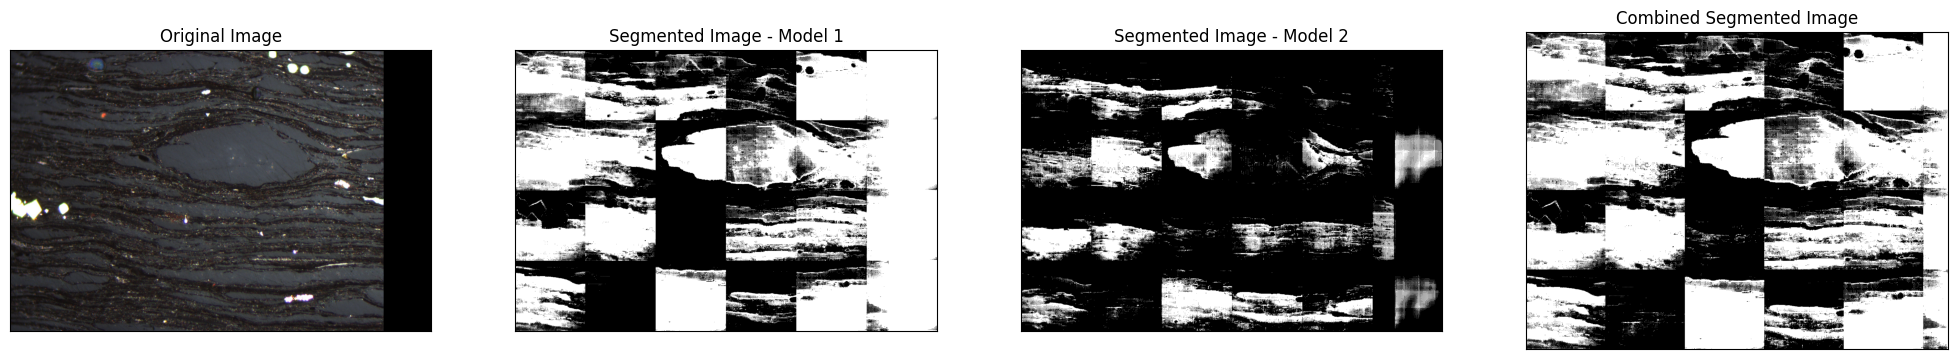

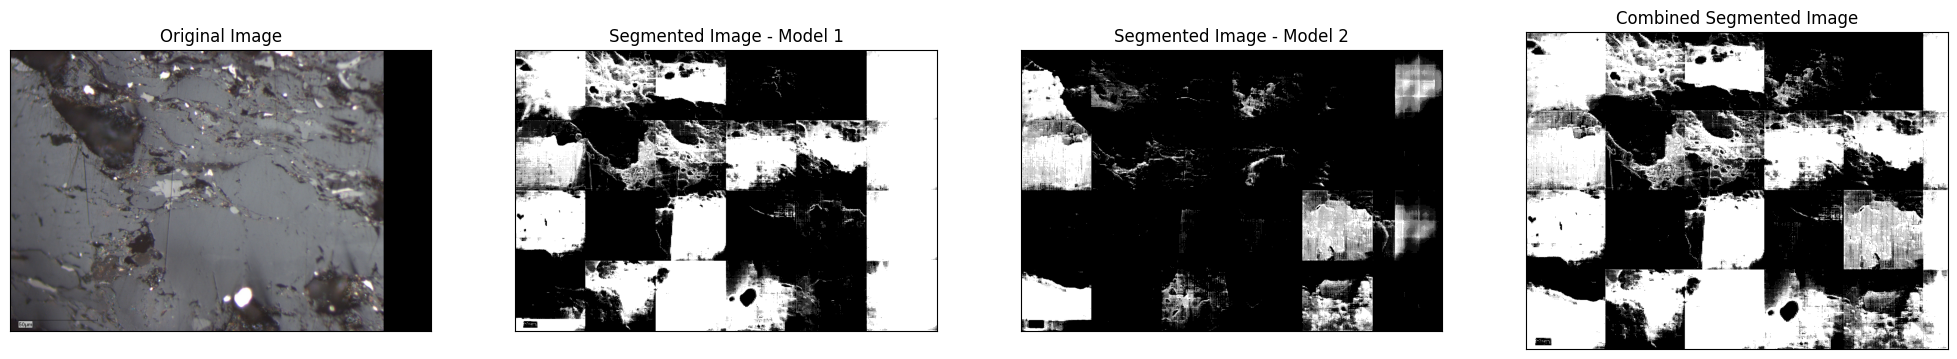

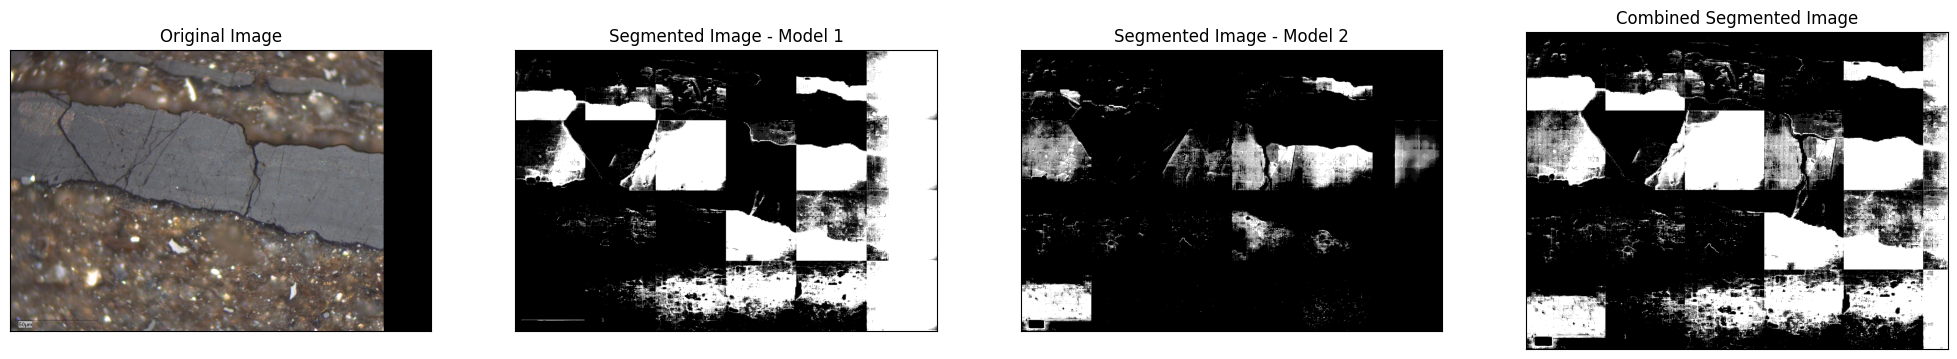

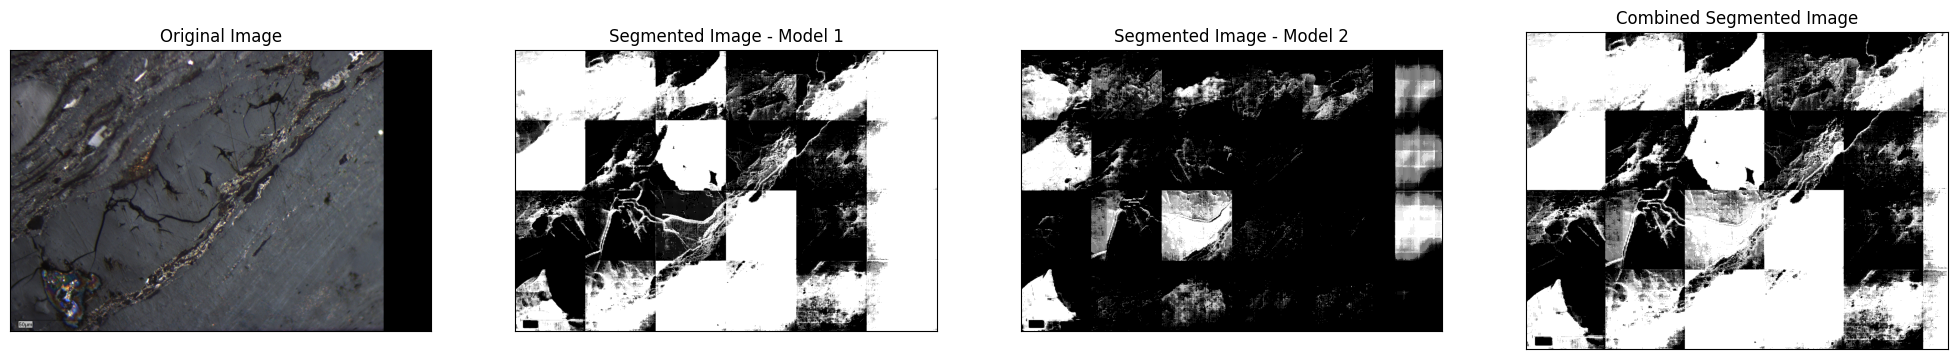

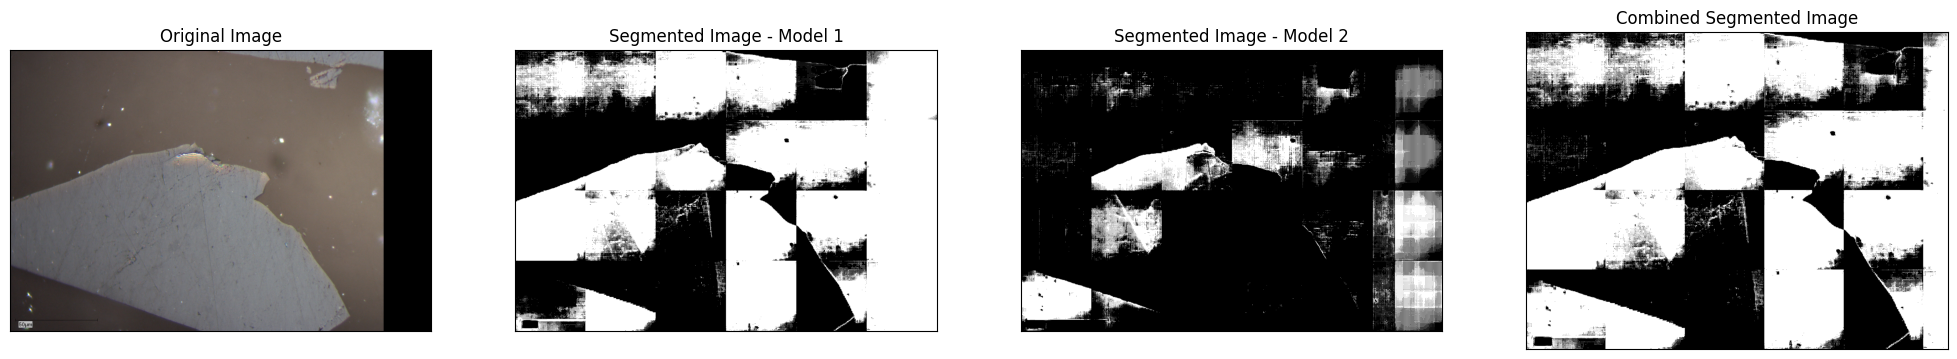

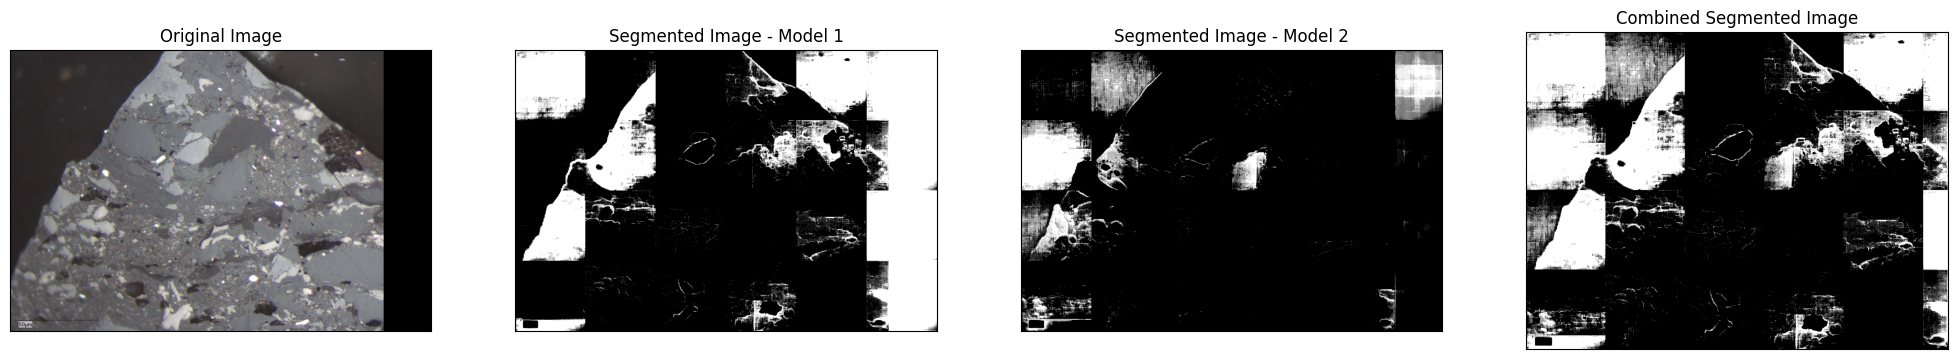

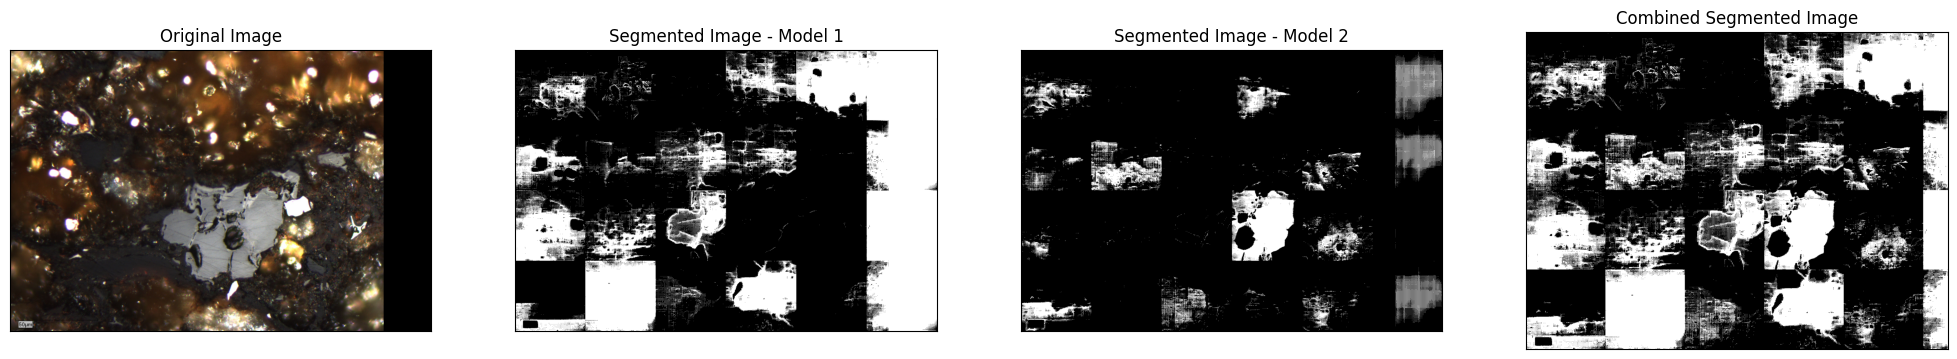

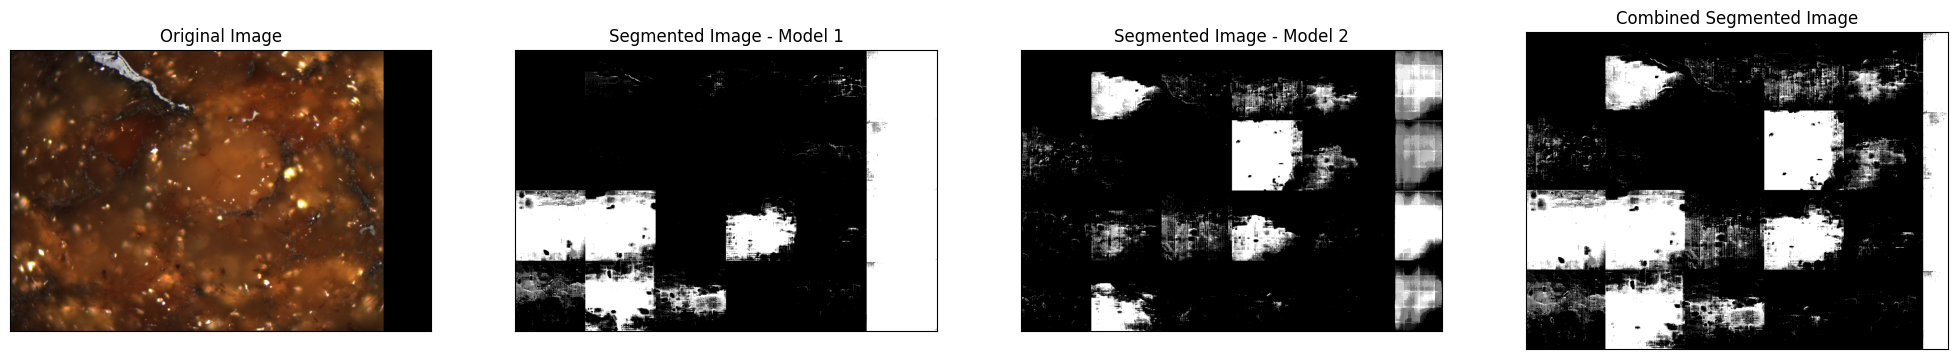

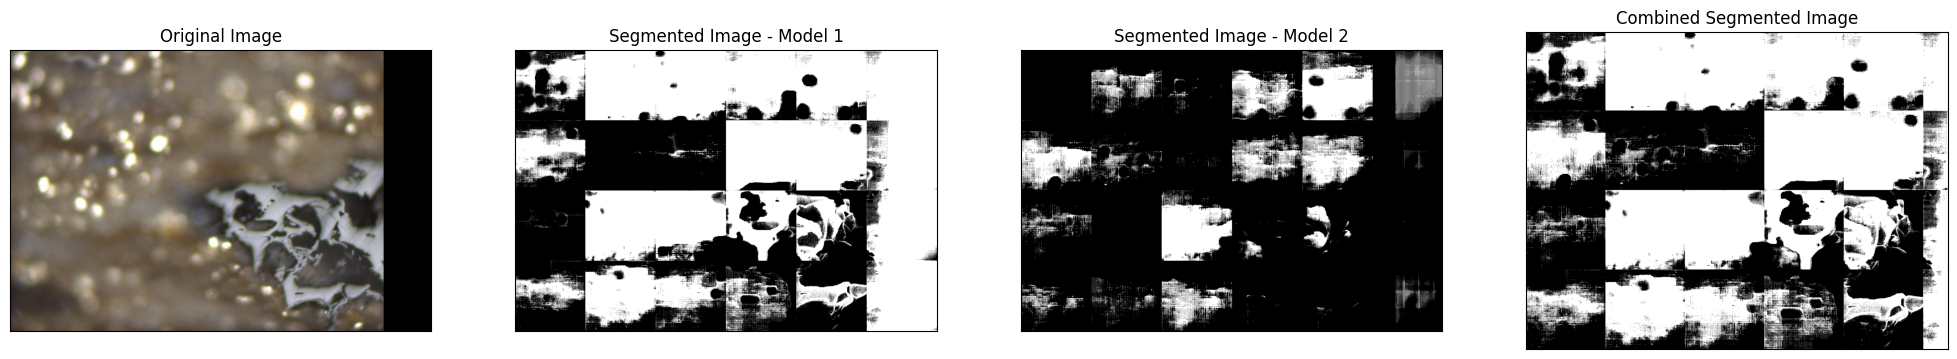

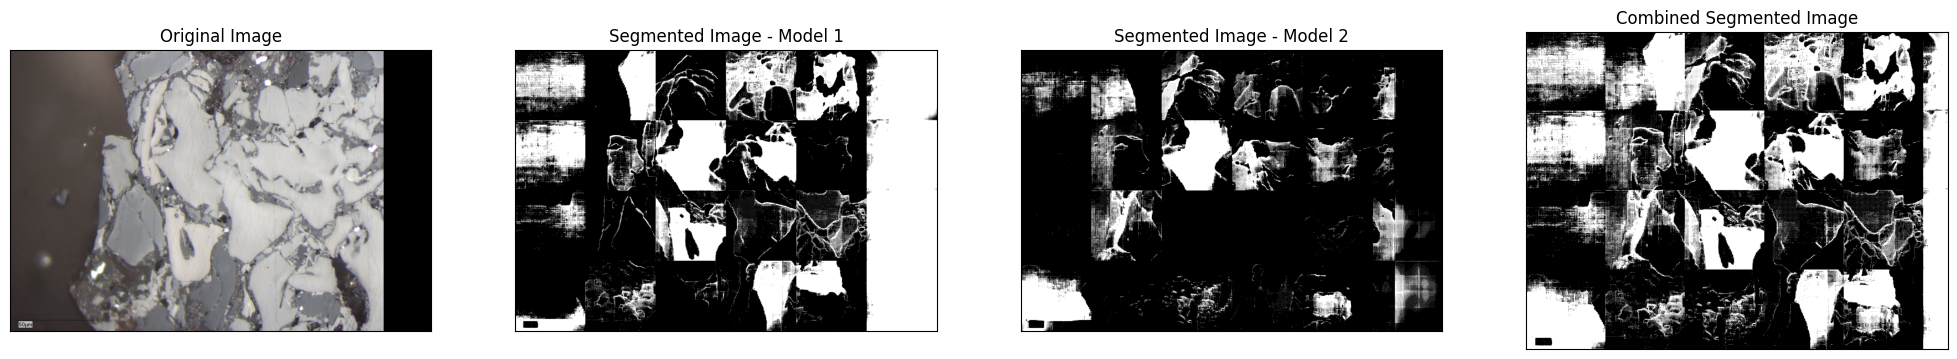

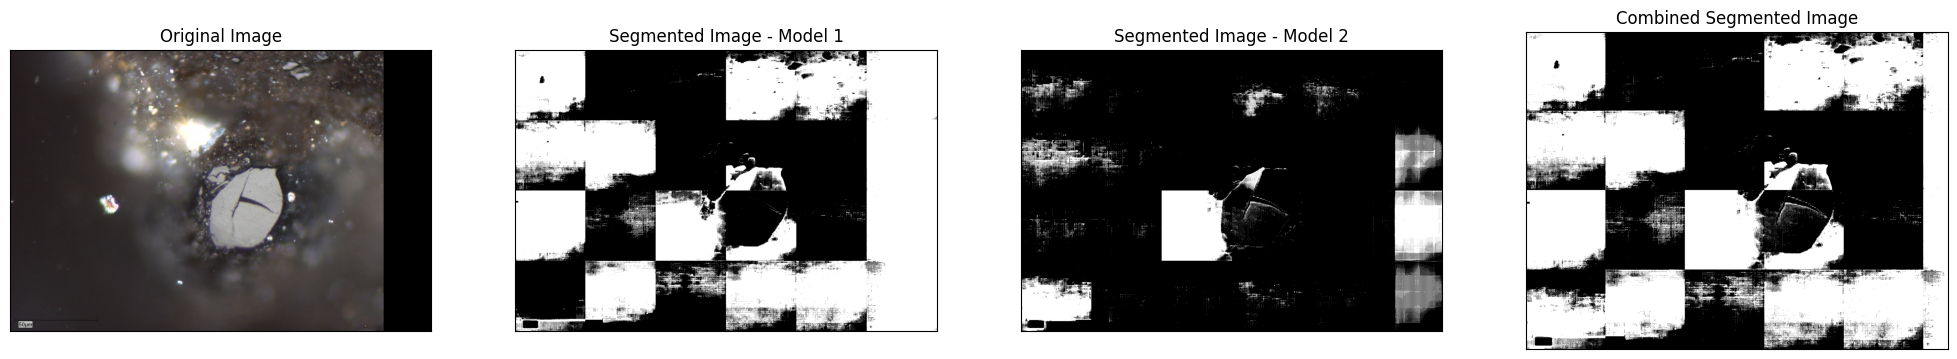

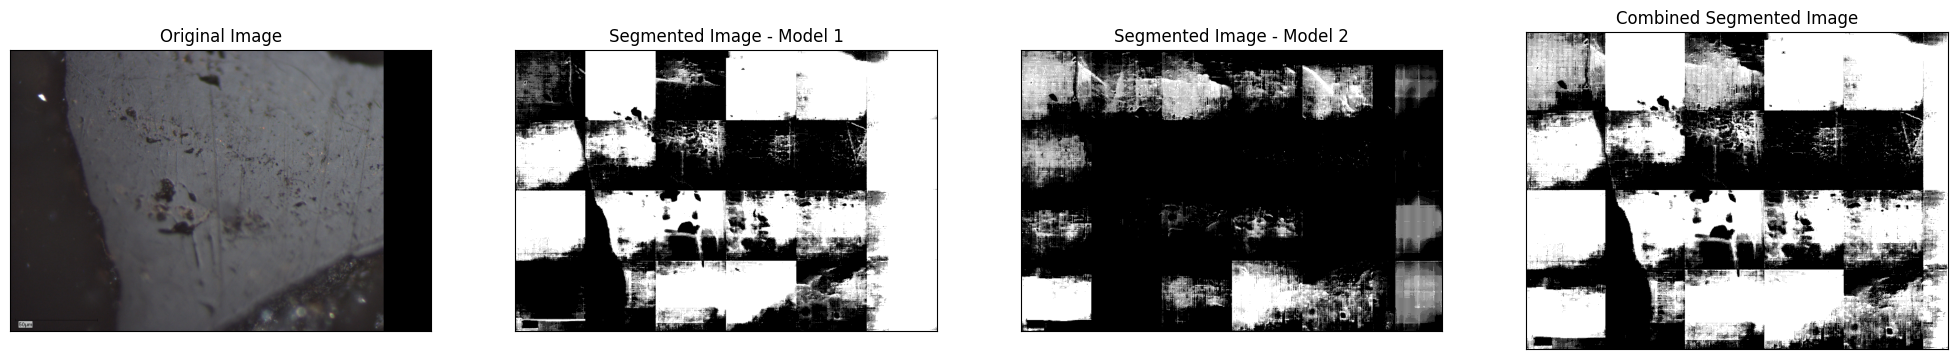

In [9]:
# Process each image in the dataset
for img_idx in range(large_test_images.shape[0]):
    image_id = image_ids[img_idx]
    image = large_test_images[img_idx]

    # Extract patches from the image
    patches = patchify(image, (patch_size, patch_size, 3), step=step_size)
    patches = np.squeeze(patches, axis=2)

    # Initialize arrays to store predicted patches for all three models
    predicted_patches_1 = np.zeros(patches.shape[:2] + (patch_size, patch_size), dtype=np.uint8)
    predicted_patches_2 = np.zeros(patches.shape[:2] + (patch_size, patch_size), dtype=np.uint8)
    # predicted_patches_3 = np.zeros(patches.shape[:2] + (patch_size, patch_size), dtype=np.uint8)

    # Process each patch
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j]
            single_patch = Image.fromarray(patch)

            # Prepare the patch for model 1
            inputs_1 = processor_1(single_patch, return_tensors="pt")
            inputs_1 = {k: v.to("cuda" if torch.cuda.is_available() else "cpu") for k, v in inputs_1.items()}
            model_seg_1.eval()

            # Forward pass for model 1
            with torch.no_grad():
                outputs_1 = model_seg_1(**inputs_1, multimask_output=False)

            # Apply sigmoid for model 1
            single_patch_prob_1 = torch.sigmoid(outputs_1.pred_masks.squeeze(1))
            single_patch_prob_1 = single_patch_prob_1.cpu().numpy().squeeze()
            single_patch_prediction_1 = (single_patch_prob_1 > 0.5).astype(np.uint8)

            # Store the prediction for model 1
            predicted_patches_1[i, j] = single_patch_prediction_1

            # Prepare the patch for model 2
            inputs_2 = processor_2(single_patch, return_tensors="pt")
            inputs_2 = {k: v.to("cuda" if torch.cuda.is_available() else "cpu") for k, v in inputs_2.items()}
            model_seg_2.eval()

            # Forward pass for model 2
            with torch.no_grad():
                outputs_2 = model_seg_2(**inputs_2, multimask_output=False)

            # Apply sigmoid for model 2
            single_patch_prob_2 = torch.sigmoid(outputs_2.pred_masks.squeeze(1))
            single_patch_prob_2 = single_patch_prob_2.cpu().numpy().squeeze()
            single_patch_prediction_2 = (single_patch_prob_2 > 0.5).astype(np.uint8)

            # Store the prediction for model 2
            predicted_patches_2[i, j] = single_patch_prediction_2

            # # Prepare the patch for model 3
            # inputs_3 = processor_3(single_patch, return_tensors="pt")
            # inputs_3 = {k: v.to("cuda" if torch.cuda.is_available() else "cpu") for k, v in inputs_3.items()}
            # model_seg_3.eval()

            # # Forward pass for model 3
            # with torch.no_grad():
            #     outputs_3 = model_seg_3(**inputs_3, multimask_output=False)

            # # Apply sigmoid for model 3
            # single_patch_prob_3 = torch.sigmoid(outputs_3.pred_masks.squeeze(1))
            # single_patch_prob_3 = single_patch_prob_3.cpu().numpy().squeeze()
            # single_patch_prediction_3 = (single_patch_prob_3 > 0.5).astype(np.uint8)

            # # Store the prediction for model 3
            # predicted_patches_3[i, j] = single_patch_prediction_3

    # Reconstruct the full image from the predicted patches for all three models
    reconstructed_image_1 = unpatchify(predicted_patches_1, (patches.shape[0] * patch_size, patches.shape[1] * patch_size))
    reconstructed_image_2 = unpatchify(predicted_patches_2, (patches.shape[0] * patch_size, patches.shape[1] * patch_size))
    # reconstructed_image_3 = unpatchify(predicted_patches_3, (patches.shape[0] * patch_size, patches.shape[1] * patch_size))

    # Combine the predictions from all three models
    combined_prediction = np.maximum(reconstructed_image_1, reconstructed_image_2)
    combined_prediction_cropped = combined_prediction[:, :1360]



    # Save the combined image as .npy file
    np.save(os.path.join(output_directory, f"{image_id}_pred.npy"), combined_prediction_cropped)

    # Apply the colormap to the combined prediction
    # combined_prediction_colored = cmap(combined_prediction_cropped / combined_prediction_cropped.max())

    # Plot and visualize the original image and the reconstructed segmented images
    fig, axes = plt.subplots(1, 4, figsize=(25, 5))

    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")

    # Plot the reconstructed segmented image from model 1
    axes[1].imshow(reconstructed_image_1, cmap='gray')
    axes[1].set_title("Segmented Image - Model 1")

    # Plot the reconstructed segmented image from model 2
    axes[2].imshow(reconstructed_image_2, cmap='gray')
    axes[2].set_title("Segmented Image - Model 2")

    # # Plot the reconstructed segmented image from model 3
    # axes[3].imshow(reconstructed_image_3, cmap='gray')
    # axes[3].set_title("Segmented Image - Model 3")

    # Plot the combined segmented image
    axes[3].imshow(combined_prediction_cropped, cmap='gray')
    axes[3].set_title("Combined Segmented Image")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Display the images side by side
    plt.show()